In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

```
python run_eval.py --model o1-preview-2024-09-12 --out outputs.jsonl --api openai --max-tokens 8192 --temperature 1
```

In [5]:
fname = BASEDIR / "outputs/short_answer/o1-preview-2024-09-12/outputs.jsonl"

responses = read_jsonl(fname)
responses = [
    {
        "uid": x["uid"],
        "system": x["system"],
        "prompt": x["prompt"],
        "response": ModelResponse.from_response(x["response"], "openai")
    }
    for x in responses
    if x["uid"] in dataset_map
]
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset)

  0%|          | 0/4780 [00:00<?, ?it/s]

0.6820083682008368

In [6]:
os.makedirs(BASEDIR / "results/o1-preview-2024-09-12", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/o1-preview-2024-09-12/results.csv")

In [7]:
results_metadata.value_counts("reason")

reason
stop      4242
length     538
Name: count, dtype: int64

In [8]:
(538 - 299) / len(dataset)

0.05

## Cost

In [9]:
PRICES = get_pricing("o1-preview-2024-09-12")
PRICES

{'input_tokens': 1.5e-05,
 'output_tokens': 6e-05,
 'cached_input_tokens': 7.5e-06}

In [10]:
total_cost = 0
for row in results_metadata.itertuples():
    total_cost += PRICES["input_tokens"] * row.input_tokens
    total_cost += PRICES["output_tokens"] * row.output_tokens
total_cost

944.1794700000233

## Accuracy

In [11]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,85.231539
2,1505,75.813953
3,1363,68.598679
4,719,52.990264
5,197,40.101523
6,197,21.827411


In [12]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,70.927835
counting_and_probability,812,68.719212
geometry,1268,58.123028
number_theory,601,73.876872
prealgebra,889,80.202475
precalculus,240,50.000000


## Output lengths

In [13]:
results_metadata["response_tokens"] = results_metadata["output_tokens"] - results_metadata["reasoning_tokens"]

<Axes: title={'center': 'reasoning_tokens'}, xlabel='level'>

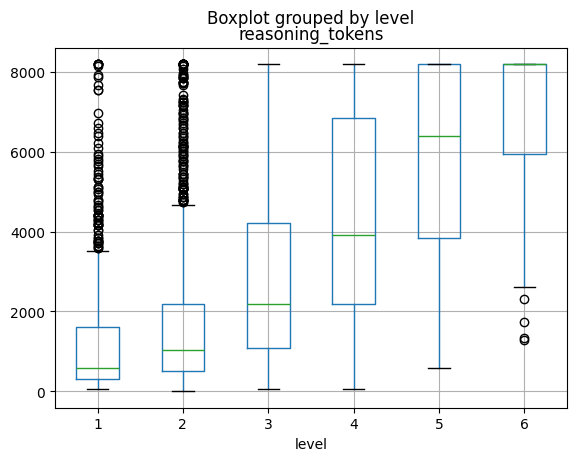

In [14]:
results_metadata.boxplot("reasoning_tokens", "level")

<Axes: title={'center': 'response_tokens'}, xlabel='level'>

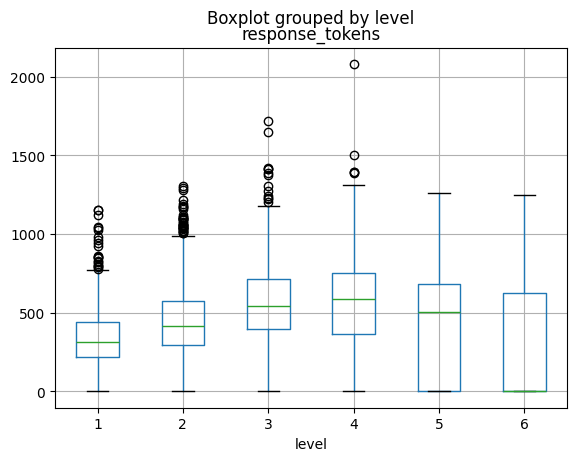

In [15]:
results_metadata.boxplot("response_tokens", "level")

<Figure size 900x600 with 0 Axes>

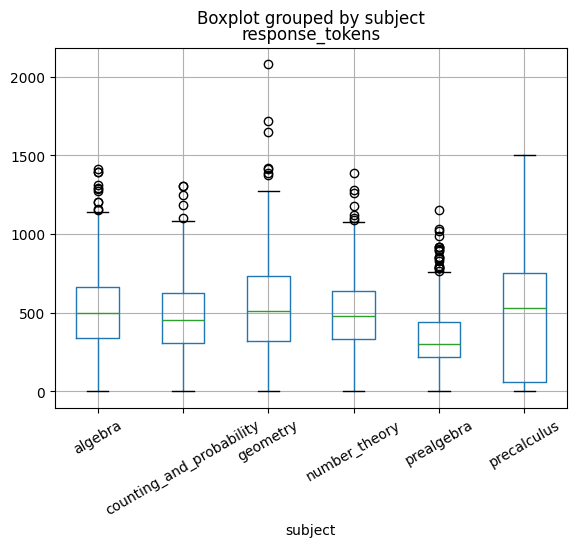

In [16]:
plt.figure(figsize=(9,6))
results_metadata.boxplot("response_tokens", "subject")
plt.xticks(rotation=30)
plt.show()